In [1]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

In [2]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [ ]:
# import asyncio

# class Agent:
#     def __init__(self, model, tools, checkpointer, system=""):
#         self.system = system
#         graph = StateGraph(AgentState)
#         graph.add_node("llm", self.call_model)
#         graph.add_edge(START, "llm")
#         graph.add_node("action", self.take_action)
#         graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
#         graph.add_edge("action", "llm")
#         graph.set_entry_point("llm")
#         graph.add_node("stream_buffer", self.handle_partial_outputs) # FIXME
#         self.graph = graph.compile(checkpointer=checkpointer)
#         self.tools = {t.name: t for t in tools}
#         self.model = model.bind_tools(tools)

#     # def call_model(self, state: AgentState):
#     #     messages = state['messages']
#     #     if self.system:
#     #         messages = [SystemMessage(content=self.system)] + messages
#     #     message = self.model.invoke(messages)
#     #     return {'messages': [message]}
#     def call_model(self, state: AgentState):
#         messages = state['messages']
#         if self.system:
#             messages = [SystemMessage(content=self.system)] + messages
#         for chunk in self.model.stream(messages):
#             yield {"messages": [chunk]}
#             if chunk.tool_calls:
#                 break  # Pause for tool execution
            
#     def handle_partial_outputs(self, state: AgentState): # FIXME
#         buffer = state.get('buffer', '')
#         for event in state['messages']:
#             if isinstance(event, str):
#                 buffer += event
#                 if len(buffer) > 50:  # Flush buffer
#                     print(buffer, end='', flush=True)
#                     buffer = ''
#         return {'buffer': buffer}

#     def exists_action(self, state: AgentState):
#         result = state['messages'][-1]
#         return len(result.tool_calls) > 0

#     # def take_action(self, state: AgentState):
#     #     tool_calls = state['messages'][-1].tool_calls
#     #     results = []
#     #     for t in tool_calls:
#     #         print(f"Calling: {t}")
#     #         result = self.tools[t['name']].invoke(t['args'])
#     #         results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
#     #     print("Back to the model!")
#     #     return {'messages': results}
    
#     async def take_action(self, state: AgentState):
#         tool_calls = state['messages'][-1].tool_calls
#         tasks = [asyncio.create_task(self._execute_tool(t)) 
#                 for t in tool_calls]
        
#         while tasks:
#             done, _ = await asyncio.wait(tasks, return_when=asyncio.FIRST_COMPLETED)
#             for task in done:
#                 yield {'messages': [task.result()]}
#             tasks = [t for t in tasks if not t.done()]

# import asyncio
# from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage
# from langgraph.graph import StateGraph, END, START
# from typing import TypedDict, Annotated
# import operator

# class AgentState(TypedDict):
#     messages: Annotated[list[AnyMessage], operator.add]
#     buffer: str

# class Agent:
#     def __init__(self, model, tools, checkpointer, system=""):
#         self.system = system
#         graph = StateGraph(AgentState)
#         graph.add_node("llm", self.call_model)
#         graph.add_edge(START, "llm")
#         graph.add_node("action", self.take_action)
#         graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
#         graph.add_edge("action", "llm")
#         graph.set_entry_point("llm")
#         graph.add_node("stream_buffer", self.handle_partial_outputs)
#         graph.add_edge("llm", "stream_buffer")
#         graph.add_edge("stream_buffer", END)
#         self.graph = graph.compile(checkpointer=checkpointer)
#         self.tools = {t.name: t for t in tools}
#         self.model = model.bind_tools(tools)

#     async def call_model(self, state: AgentState):
#         messages = state['messages']
#         if self.system:
#             messages = [SystemMessage(content=self.system)] + messages
#         async for chunk in self.model.astream(messages):
#             yield {"messages": [chunk]}
#             if chunk.tool_calls:
#                 break  # Pause for tool execution

#     def handle_partial_outputs(self, state: AgentState):
#         buffer = state.get('buffer', '')
#         for event in state['messages']:
#             if isinstance(event, AIMessage):
#                 content = event.content or ""
#                 buffer += content
#                 if len(buffer) > 50:  # Flush buffer
#                     print(buffer, end='', flush=True)
#                     buffer = ''
#         return {'buffer': buffer}

#     def exists_action(self, state: AgentState):
#         result = state['messages'][-1]
#         return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

#     async def take_action(self, state: AgentState):
#         tool_calls = state['messages'][-1].tool_calls
#         tasks = [asyncio.create_task(self._execute_tool(t)) 
#                 for t in tool_calls]
        
#         results = []
#         while tasks:
#             done, tasks = await asyncio.wait(tasks, return_when=asyncio.FIRST_COMPLETED)
#             for task in done:
#                 results.append(await task)
        
#         return {'messages': results}

#     async def _execute_tool(self, tool_call):
#         print(f"Calling: {tool_call}")
#         result = await self.tools[tool_call.name].ainvoke(tool_call.arguments)
#         return ToolMessage(tool_call_id=tool_call.id, name=tool_call.name, content=str(result))


import asyncio
import json
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Annotated
import operator

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    buffer: str

class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_model)
        graph.add_edge(START, "llm")
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        graph.add_node("stream_buffer", self.handle_partial_outputs)
        graph.add_edge("llm", "stream_buffer")
        graph.add_edge("stream_buffer", END)
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    async def call_model(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        async for chunk in self.model.astream(messages):
            print(f"Received chunk: {chunk}")
            yield {"messages": [chunk], "buffer": chunk.content if chunk.content else ""}
            if chunk.tool_calls:
                break  # Pause for tool execution

    def handle_partial_outputs(self, state: AgentState):
        buffer = state.get('buffer', '')
        return {'buffer': buffer}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

    async def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        tasks = [asyncio.create_task(self._execute_tool(t)) 
                for t in tool_calls]
        
        results = []
        while tasks:
            done, tasks = await asyncio.wait(tasks, return_when=asyncio.FIRST_COMPLETED)
            for task in done:
                results.append(await task)
        
        return {'messages': results}

    async def _execute_tool(self, tool_call):
        print(f"Calling: {tool_call}")
        tool_name = tool_call.name if hasattr(tool_call, 'name') else tool_call.get('name')
        
        # Handle different possible structures of tool_call
        if hasattr(tool_call, 'arguments'):
            tool_args = tool_call.arguments
        elif 'arguments' in tool_call:
            tool_args = tool_call['arguments']
        elif 'args' in tool_call:
            tool_args = tool_call['args']
        else:
            tool_args = {}

        # If tool_args is a string, try to parse it as JSON
        if isinstance(tool_args, str):
            try:
                tool_args = json.loads(tool_args)
            except json.JSONDecodeError:
                # If it's not valid JSON, use it as is
                tool_args = {"question": tool_args}

        # Ensure tool_args is a dictionary
        if not isinstance(tool_args, dict):
            tool_args = {"question": str(tool_args)}

        # Ensure 'k' is present in tool_args
        if 'k' not in tool_args:
            tool_args['k'] = 10  # default value

        result = await self.tools[tool_name].ainvoke(input=tool_args)
        return ToolMessage(
            tool_call_id=tool_call.id if hasattr(tool_call, 'id') else tool_call.get('id', ''),
            name=tool_name,
            content=str(result)
        )



In [4]:
import sys
sys.path.append('/home/TomKerby/Research/lit_review/configs')
from new_llm_config import config

sys.path.append('/home/TomKerby/Research/lit_review/lit_review')
import utils
from agent_tools import SearchNeo4jVectorTool
import rag_utils as rag

from langchain_neo4j import Neo4jVector

kg = utils.load_kg(config)
# llm_adapter = rag.get_llm(config)
emb_adapter = rag.get_embeddings(config)

custom_query = """
MATCH (c:Chunk)
WITH DISTINCT c, vector.similarity.cosine(c.textEmbedding, $embedding) AS score
ORDER BY score DESC LIMIT $k
RETURN c.text AS text, score, {source: c.source, chunkId: c.chunkId} AS metadata
"""

chunk_vector = Neo4jVector.from_existing_index(
    emb_adapter.embeddings,
    graph=kg, 
    index_name=config["rag"]["index_name"],
    embedding_node_property=config["rag"]["embedding_node_property"],
    text_node_property=config["rag"]["text_node_property"],
    retrieval_query=custom_query,
)

tool = SearchNeo4jVectorTool(vector_db=chunk_vector)

In [10]:
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver

llm_config = config['llm']

model = ChatOllama(
    model=llm_config["model_id"],
    num_ctx=llm_config.get("num_ctx", 32768),
    num_predict=llm_config.get("num_predict", 4096),
    temperature=llm_config.get("temperature", 0.5)
)

prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

checkpointer = MemorySaver()

abot = Agent(model, [tool], system=prompt, checkpointer=checkpointer)

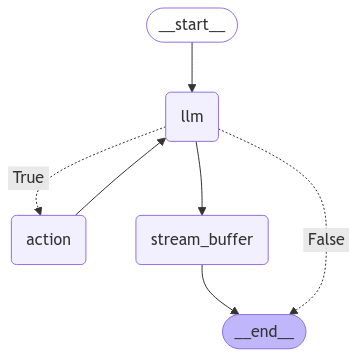

In [6]:
from IPython.display import Image, display

try:
    display(Image(abot.graph.get_graph().draw_mermaid_png()))
except:
    pass

In [16]:
thread = {"configurable": {"thread_id": '2'}}
inputs = {'messages': [HumanMessage(content="Please give a thorough and comprehensive list of some of the ways that the structure of a latent space in a diffusion model can be leveraged to help control the generation process?")]}

async for chunk_msg, metadata in abot.graph.astream(inputs, thread, stream_mode="messages"):
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)
    else:
        print(chunk_msg.content)
        print(f"\n\nmetadata: \n{metadata}\n\n")

Received chunk: content='' additional_kwargs={} response_metadata={} id='run-2f406a60-6dec-4ca0-8127-7e60300e9f86' tool_calls=[{'name': 'search_chunks', 'args': {'k': 10, 'question': 'latent space structure control in diffusion models'}, 'id': '865e6f56-8c17-460c-b3af-3b09e1c5f25f', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'search_chunks', 'args': '{"k": 10, "question": "latent space structure control in diffusion models"}', 'id': '865e6f56-8c17-460c-b3af-3b09e1c5f25f', 'index': None, 'type': 'tool_call_chunk'}]



metadata: 
{'thread_id': '2', 'langgraph_step': 16, 'langgraph_node': 'llm', 'langgraph_triggers': ['start:llm'], 'langgraph_path': ('__pregel_pull', 'llm'), 'langgraph_checkpoint_ns': 'llm:336ad963-4b9f-9d61-2e86-f5fbd229a01d', 'checkpoint_ns': 'llm:336ad963-4b9f-9d61-2e86-f5fbd229a01d', 'ls_provider': 'ollama', 'ls_model_name': 'llama3.3', 'ls_model_type': 'chat', 'ls_temperature': 0.5}


Calling: {'name': 'search_chunks', 'args': {'k': 10, 'question': 'latent spac

In [11]:
thread = {"configurable": {"thread_id": '2'}}
messages = [HumanMessage(content="Please give a thorough and comprehensive list of some of the ways that the structure of a latent space in a diffusion model can be leveraged to help control the generation process?")]

async def run_agent():
    buffer = ""
    async for event in abot.graph.astream({"messages": messages, "buffer": ""}, thread, stream_mode="updates"):
        if 'buffer' in event:
            new_content = event['buffer']
            buffer += new_content
            print(new_content, end='', flush=True)

await run_agent()

# To get the final state:
final_state = abot.graph.get_state(thread)
final_message = final_state.values['messages'][-1]
final_message.pretty_print()


Received chunk: content='' additional_kwargs={} response_metadata={} id='run-39202feb-7715-43e9-8e15-063fc726478d' tool_calls=[{'name': 'search_chunks', 'args': {'k': 10, 'question': 'latent space structure control in diffusion models'}, 'id': 'db0d3838-8c94-40cc-aaf8-501dce757c3b', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'search_chunks', 'args': '{"k": 10, "question": "latent space structure control in diffusion models"}', 'id': 'db0d3838-8c94-40cc-aaf8-501dce757c3b', 'index': None, 'type': 'tool_call_chunk'}]
Calling: {'name': 'search_chunks', 'args': {'k': 10, 'question': 'latent space structure control in diffusion models'}, 'id': 'db0d3838-8c94-40cc-aaf8-501dce757c3b', 'type': 'tool_call'}
Received chunk: content='The structure of a latent space in a diffusion model can be leveraged to help control the generation process in several ways:\n\n1. **Semantic Latent Space**: Discovering a semantic latent space in pretrained diffusion models allows for versatile editing and qua

In [8]:
thread = {"configurable": {"thread_id": '2'}}
messages = [HumanMessage(content="Can you discuss item number 2 in more depth?")]
await run_agent()

final_state = abot.graph.get_state(thread)
final_message = final_state.values['messages'][-1]
final_message.pretty_print()

Received chunk: content='' additional_kwargs={} response_metadata={} id='run-de0d1784-5bdc-4ee6-a77a-c7419e74f7f5' tool_calls=[{'name': 'search_chunks', 'args': {'k': 10, 'question': 'item number 2 discussion'}, 'id': '7f8ec375-ba23-456a-a231-07c9358100f4', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'search_chunks', 'args': '{"k": 10, "question": "item number 2 discussion"}', 'id': '7f8ec375-ba23-456a-a231-07c9358100f4', 'index': None, 'type': 'tool_call_chunk'}]
Calling: {'name': 'search_chunks', 'args': {'k': 10, 'question': 'item number 2 discussion'}, 'id': '7f8ec375-ba23-456a-a231-07c9358100f4', 'type': 'tool_call'}
Received chunk: content='Item number 2 refers to the concept of a "Smooth Latent Space" in diffusion models. This concept is related to the idea of investigating the latent space smoothness for diffusion models, which remains unexplored.\n\nIn the context of diffusion models, the latent space is the space where the input data is represented after passing through 

In [ ]:
thread = {"configurable": {"thread_id": '1'}}
messages = [HumanMessage(content="Who wrote the paper titled: Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models")]
async for event in abot.graph.astream({"messages":messages,}, thread, stream_mode="updates"):
    pass
abot.graph.get_state(thread).values['messages'][-1].pretty_print()

In [ ]:
thread = {"configurable": {"thread_id": '1'}}
messages = [HumanMessage(content="How would you summarize the paper in 4 sentences?")]
async for event in abot.graph.astream({"messages":messages,}, thread, stream_mode="updates"):
    pass
abot.graph.get_state(thread).values['messages'][-1].pretty_print()